# Konvolutivni slojevi verzija 1

In [13]:
import os
import cv2
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report

Lokacija dataset-a

In [14]:
dataset_path = "../data_set"

In [15]:
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]


Inicijalizacija lista za cuvanje podataka


In [16]:
data = []
labels = []

Ucitavanje slika kroz klase


In [17]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Training", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Učitavanje slike u crno-belom formatu
        img = cv2.resize(img, (224, 224))  # Da sve slike budu 224x224px
        data.append(img)
        labels.append(classes.index(class_name))

Konvertovanje listi u numpy


In [18]:
data = np.array(data) / 255.0  # Normalizacija vrednosti piksela
data = np.expand_dims(data, axis=-1)
labels = np.array(labels)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)


ImageDataGenerator za data augmentation


In [20]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

CNN model sa konvolutivnim slojevima

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))

In [22]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [23]:
# Podešavanje EarlyStopping callback-a
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metrika koja se prati
    min_delta=0.01,  # Minimalna promena koja se detektuje kao poboljšanje
    patience=5,  # Broj epoha bez poboljšanja nakon kojih se obustavlja treniranje
    restore_best_weights=True  # Vraćanje težina modela iz epohe sa najboljom vrednošću nadgledane metrike
)

In [24]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
    epochs=70,  # veći broj, jer treniranje može biti prekinuto ranije
    callbacks=[early_stopping]  # early stopping
)

Epoch 1/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5193 - loss: 1.0853 - val_accuracy: 0.7770 - val_loss: 0.5349
Epoch 2/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8057 - loss: 0.4896 - val_accuracy: 0.8397 - val_loss: 0.4712
Epoch 3/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8981 - loss: 0.3006 - val_accuracy: 0.8188 - val_loss: 0.4225
Epoch 4/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9544 - loss: 0.1294 - val_accuracy: 0.8606 - val_loss: 0.3728
Epoch 5/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9710 - loss: 0.0918 - val_accuracy: 0.9077 - val_loss: 0.3721
Epoch 6/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.9890 - loss: 0.0365 - val_accuracy: 0.9042 - val_loss: 0.3288
Epoch 7/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9942 - loss: 0.0223 - val_accuracy: 0.9059 - val_loss: 0.3729
Epoch 8/70
72/72 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9961 - loss: 0.0125 - val_accuracy: 0.9111 - v

Evaluacija modela na test skupu

In [25]:
test_data = []
test_labels = []

In [26]:
for class_name in classes:
    class_path = os.path.join(dataset_path, "Testing", class_name)
    for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Učitavanje slike u crno-belom formatu
        img = cv2.resize(img, (224, 224))
        test_data.append(img)
        test_labels.append(classes.index(class_name))


In [27]:
test_data = np.array(test_data) / 255.0
test_data = np.expand_dims(test_data, axis=-1)
test_labels = np.array(test_labels)


Classification report

In [28]:

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step


In [29]:
report = classification_report(test_labels, predicted_classes, target_names=classes)
print("Classification Report:")
print(report)

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.20      0.33       100
meningioma_tumor       0.66      0.89      0.76       115
        no_tumor       0.63      0.91      0.75       105
 pituitary_tumor       0.84      0.77      0.80        74

        accuracy                           0.70       394
       macro avg       0.78      0.69      0.66       394
    weighted avg       0.77      0.70      0.66       394



Model pokazuje dobre performanse u klasifikaciji meningioma tumora i slika bez tumora, dok ima problema sa detekcijom glioma tumora.

Precision za glioma tumor je visok, ali recall je veoma nizak, što znači da model propušta mnogo stvarnih slučajeva glioma tumora.

Odziv je visok za meningioma tumore i slike bez tumora, ali veoma nizak za glioma tumore, što znači da model propušta veliki broj stvarnih slučajeva glioma tumora.

F1-score vrednosti pokazuju da model ima solidne performanse za većinu klasa osim za glioma tumor. 

Ukupna tačnost modela je 70%, što je solidno, ali postoji prostor za poboljšanje, posebno u detekciji glioma tumora.

Kreiranje tabele sa rezultatima

In [30]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)

In [31]:
results = {
    "Model": ["CNN - v1"],
    "Train Loss": [train_loss],
    "Train Accuracy": [train_accuracy],
    "Validation Loss": [val_loss],
    "Validation Accuracy": [val_accuracy],
    "Test Loss": [test_loss],
    "Test Accuracy": [test_accuracy]
}

In [32]:
results_df = pd.DataFrame(results)

# Čuvanje tabele rezultata kao CSV fajl
results_df.to_csv("model_results_cnn1.csv", index=False)

In [33]:
print(results_df)

      Model  Train Loss  Train Accuracy  Validation Loss  Validation Accuracy  \
0  CNN - v1    0.019355         0.99608         0.305284             0.897213   

   Test Loss  Test Accuracy  
0    3.40406        0.69797  


Rezultati

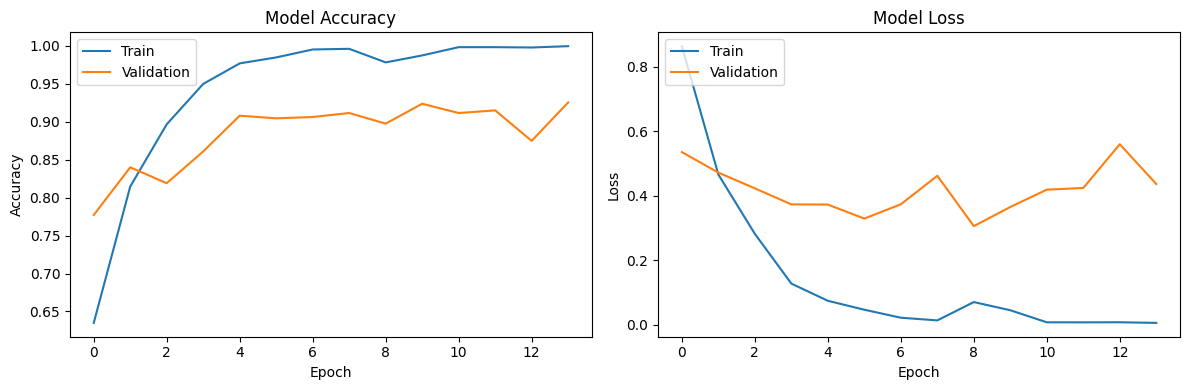

In [36]:
# train history
plt.figure(figsize=(12, 4))

#training, validation accuracy 
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# training validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Accuracy**

Tacnost na trening setu brzo raste već nakon prvih nekoliko epoha, dosezuci vrlo visoke vrednosti (iznad 0.95), sto pokazuje da model efikasno uci iz trening podataka.
Razlika između Treninga i Validacije: Tacnost na validacionom setu prati trening tacnost do određene mere, ali postoji vidljiva razlika i neka varijacija, posebno nakon oko 5. epohe. Ovo može biti indikacija početka preprilagođavanja, jer model bolje radi na trening podacima nego na validacionim.

**Loss**

Greska na trening setu brzo opada u prvim epohama i ostaje na niskom nivou, što sugeriše da model brzo minimizira greške na trening podacima.
Greska validacije nakon inicijalnog pada, pokazuje varijacije i generalno veće vrednosti u poređenju sa trening greskom, što ponovo može ukazivati na preprilagođavanje

Uzeti sve ovo u obzir ovo je najbolji model sa tacnoscu na test skupu od 0.69797  

